# importing data from kaggle using kagglehub

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
paultimothymooney_chest_xray_pneumonia_path

'/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2'

In [ ]:
os.listdir('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/')

['chest_xray', 'train', 'val', '__MACOSX', 'test']

In [ ]:
train='/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train'
test='/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test'
valid='/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val'

In [ ]:
print(os.listdir(train)), print(os.listdir(test)), print(os.listdir(valid))

['PNEUMONIA', 'NORMAL']
['PNEUMONIA', 'NORMAL']
['PNEUMONIA', 'NORMAL']


(None, None, None)

# Loading images using image_dataset_from_directory module

In [ ]:
from keras.preprocessing import image_dataset_from_directory

train_data = image_dataset_from_directory(train,
                                          label_mode='binary',
                                          color_mode='grayscale',
                                          subset='training',
                                          seed=123,
                                          validation_split=0.2)

valid_data = image_dataset_from_directory(train,
                                          label_mode='binary',
                                          color_mode='grayscale',
                                          subset='validation',
                                          seed=123,
                                          validation_split=0.2)

test_data = image_dataset_from_directory(test,
                                         label_mode='binary',
                                         color_mode='grayscale')

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


# Visualization

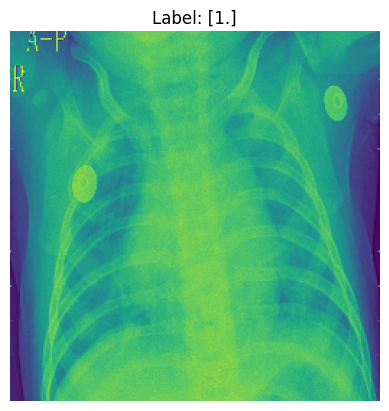

In [ ]:
import matplotlib.pyplot as plt

for images, labels in train_data.take(1):
    plt.imshow(images[0].numpy().astype("uint8")) # Using uint8 ensures that pixel values fall within 255 range
    plt.title(f"Label: {labels[0].numpy()}")
    plt.axis("off")
    plt.show()

In [ ]:
for images, labels in train_data.take(1):
  NUM_CLASSES = len(labels.shape)

# Data Augmentation

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras

data_augmentation = keras.Sequential([
    layers.Input((256, 256, 1)),
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])

# Preparing the architecture to train images

In [ ]:
from keras.layers import Dense, Rescaling, Conv2D, Input, Flatten, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.models import Model, Sequential

model = Sequential()

model.add(Input(shape=(256, 256, 1)))
model.add(data_augmentation)
model.add(Rescaling(1. / 255))
model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 128)       │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │     536,871,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 536,947,521 (2.00 GB)

 Trainable params: 536,947,265 (2.00 GB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
from keras.optimizers import Adam

opt = Adam(learning_rate=0.00001)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping

early = EarlyStopping(patience=5, monitor='val_loss',  restore_best_weights=True )

# Training

In [ ]:
model.fit(train_data,
          epochs=50,
          validation_data=valid_data,
          callbacks=[early])

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 106s 779ms/step - accuracy: 0.7255 - loss: 0.9210 - val_accuracy: 0.9012 - val_loss: 0.5810
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 138s 749ms/step - accuracy: 0.8509 - loss: 0.3357 - val_accuracy: 0.9022 - val_loss: 0.4920
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 780ms/step - accuracy: 0.8920 - loss: 0.2742 - val_accuracy: 0.9252 - val_loss: 0.3524
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 142s 781ms/step - accuracy: 0.8875 - loss: 0.2769 - val_accuracy: 0.9377 - val_loss: 0.2311
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 104s 793ms/step - accuracy: 0.9018 - loss: 0.2473 - val_accuracy: 0.9473 - val_loss: 0.1717
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 107s 813ms/step - accuracy: 0.9135 - loss: 0.2205 - val_accuracy: 0.9511 - val_loss: 0.1485
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 141s 804ms/step - accuracy: 0.9114 - loss: 0.2261 - val_accuracy: 0.9415 - val_loss: 0.1451
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 93s 708ms/step - accuracy: 0.9130 - 

In [ ]:
model.evaluate(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.8885 - loss: 0.3159


[0.3345414698123932, 0.8846153616905212]

# visualizing trained images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


<ipython-input-71-1937aded325a>:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_class_label = class_names[int(actual_class)]


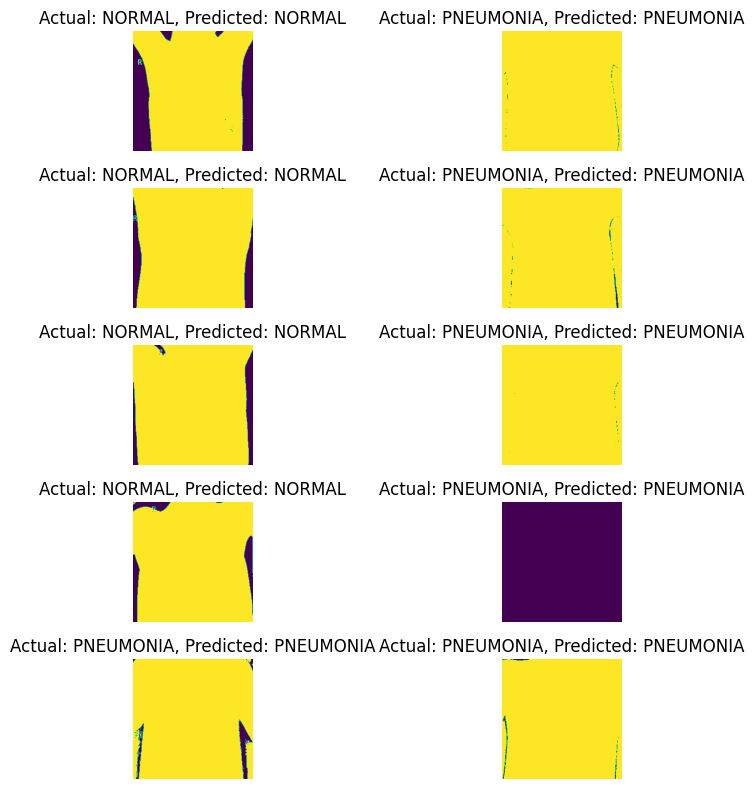

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

images, labels = next(iter(train_data)) # accessing first batch or images and labels(using for image_dataset_from_directory module)

predicted_data = model.predict(images)

predicted_labels = (predicted_data > 0.5).astype("int32")

# Number of images to display
num_images = 10

# Randomly select indices to display
random_indices = np.random.choice(images.shape[0], num_images, replace=False)

# Create a plot for the images
plt.figure(figsize=(10, 8))

for i, idx in enumerate(random_indices):
    actual_class = labels[idx].numpy()
    predicted_class = predicted_labels[idx][0]


    img = images[idx].numpy()
    img = np.clip(img, 0, 1)

    # Display the image
    plt.subplot(5, 2, i + 1)
    plt.imshow(img)
    plt.axis('off')

    # class labels for actual and predicted classes
    class_names = train_data.class_names  # class names

    # Converting actual_class and predicted_class to scalar integers (index)
    actual_class_label = class_names[int(actual_class)]
    predicted_class_label = class_names[int(predicted_class)]

    # title
    plt.title(f"Actual: {actual_class_label}, Predicted: {predicted_class_label}")

# plotting
plt.tight_layout()
plt.show()
